In [37]:
import pandas as pd
import numpy as np

In [38]:
df=pd.read_csv('Shot_Creation.csv')

In [39]:
df.drop(columns=['Matches'],inplace=True)

In [40]:
df.head()

,Player,Nation,Pos,Age,90s,SCA,SCA90,PassLive,PassDead,TO,...,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
0,Mohamed Salah,eg EGY,FW,32-342,36.5,164,4.50,119,2,22,...,5,2,27,0.74,20,0,5,2,0,0
1,Virgil van Dijk,nl NED,DF,33-319,36.0,48,1.33,41,0,1,...,1,2,4,0.11,4,0,0,0,0,0
2,Ryan Gravenberch,nl NED,MF,23-007,34.4,66,1.92,58,0,5,...,0,1,6,0.17,6,0,0,0,0,0
3,Alexis Mac Allister,ar ARG,MF,26-150,28.9,120,4.15,83,24,2,...,2,3,15,0.52,10,3,0,2,0,0
4,Ibrahima Konaté,fr FRA,DF,25-363,27.8,31,1.12,26,0,0,...,0,1,7,0.25,6,0,0,0,0,1


In [41]:
df.tail()

,Player,Nation,Pos,Age,90s,SCA,SCA90,PassLive,PassDead,TO,...,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
606,Ronnie Edwards,eng ENG,DF,22-056,0.1,0,0.00,0,0,0,...,0,0,0,0.00,0,0,0,0,0,0
607,Carlos Alcaraz,ar ARG,MF,22-174,0.1,1,9.00,1,0,0,...,0,0,0,0.00,0,0,0,0,0,0
608,Joachim Kayi Sanda,fr FRA,DF,18-175,0.1,0,0.00,0,0,0,...,0,0,0,0.00,0,0,0,0,0,0
609,Squad Total,NaN,NaN,26.1,37.0,604,16.32,423,55,48,...,27,7,40,1.08,23,4,3,8,1,1
610,Opponent Total,NaN,NaN,27.1,37.0,1164,31.46,839,82,67,...,51,38,140,3.78,91,12,10,14,7,6


# Cleaning The Data of the Squad Total And Opponent Total

In [42]:
df = df[df['Player'] != 'Squad Total']
df = df[df['Player'] != 'Opponent Total']

In [54]:
df.columns

Index(['Player', 'Nation', 'Pos', 'Age', '90s', 'SCA', 'SCA90', 'PassLive',
       'PassDead', 'TO', 'Sh', 'Fld', 'Def', 'GCA', 'GCA90', 'PassLive.1',
       'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1', 'TotalSCA'],
      dtype='object')

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
90s,571.0,14.228897,11.430861,0.0,3.550,11.80,24.250,37.00
SCA,571.0,29.588441,33.700442,0.0,4.000,17.00,44.000,200.00
SCA90,571.0,2.158546,2.416471,0.0,0.805,1.74,2.995,32.73
PassLive,571.0,21.950963,24.581216,0.0,3.000,13.00,34.000,132.00
PassDead,571.0,2.355517,5.455213,0.0,0.000,0.00,2.000,41.00
TO,571.0,1.672504,3.115259,0.0,0.000,0.00,2.000,22.00
Sh,571.0,1.849387,2.671831,0.0,0.000,1.00,3.000,21.00
Fld,571.0,1.239930,2.106019,0.0,0.000,0.00,2.000,14.00
Def,571.0,0.520140,0.977392,0.0,0.000,0.00,1.000,7.00
GCA,571.0,3.218914,4.320420,0.0,0.000,2.00,4.000,27.00


In [44]:
df_dropped=df[df['Player'] !='Squad Total']
df2=df_dropped[df_dropped['Player'] !='Opponent Total']

### Removing any players who played less than 5 games in total minuted

In [45]:
df2=df2[df2['90s']>=5]

### Check NaNs

In [46]:
df2.isna().values.any()

False

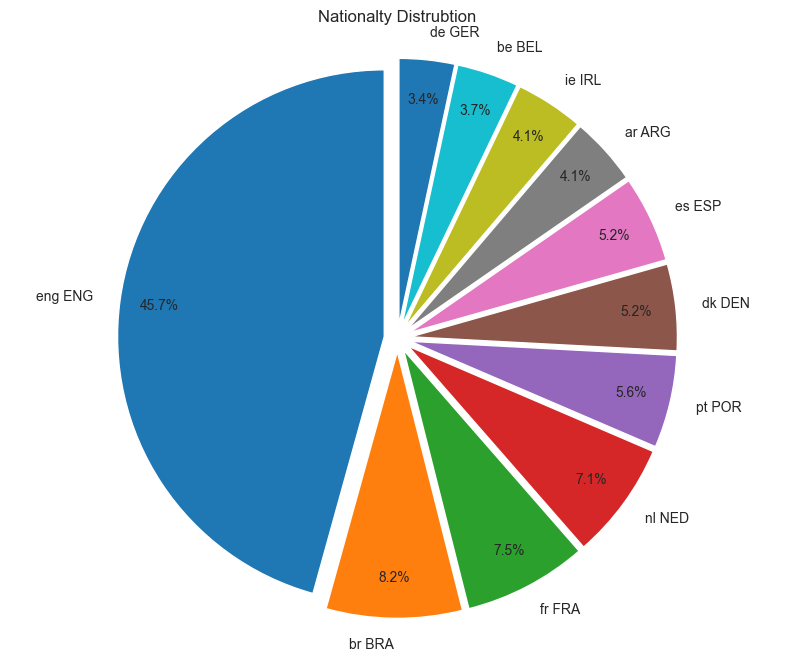

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
c=df2['Nation'].value_counts()
f=c[c>8]
explode = [0.05] * len(f)
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
plt.pie(f,labels=f.index,autopct='%1.1f%%',startangle=90,explode=explode,labeldistance=1.1,pctdistance=0.85)
plt.title('Nationalty Distrubtion')
plt.axis('equal')
plt.show()

In [48]:
min_sca=20
scatter_df=df2[(df2['SCA'] >= min_sca)]
import plotly.express as px
fig=px.scatter(scatter_df,x='SCA',y='GCA',hover_name='Player',title='Goal Creating Actions vs Shot Creating Actions Live or Dead Balls')
fig.update_layout(
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)
fig.show()

In [49]:
min_take_ons=6
bar_df=df2[df2['TO']>= min_take_ons]
fig=px.bar(bar_df,x='Player',y='TO',title='Successful Takeons that lead to a Shot')
fig.show()

In [50]:
sca_types = ['PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def']
# Select top 10 players by total SCAs
top_players = df2.groupby('Player')[sca_types].sum().sum(axis=1).nlargest(10).index

# Filter and rename
df_top = df2[df2['Player'].isin(top_players)]
df_grouped = df_top.groupby('Player')[sca_types].sum().reset_index()
# Melt into long format for stacked bar chart
df_melted = df_grouped.melt(id_vars='Player', var_name='action_type', value_name='count')

# Plot
fig = px.bar(df_melted, x='count', y='Player', color='action_type',
             title='SCA Type Breakdown (Top 10 Players)',
             orientation='h', text='count')

fig.update_layout(barmode='stack', yaxis={'categoryorder': 'total ascending'})
fig.show()

In [51]:
gca_types = ['PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1']
# Rename them for clarity in the graph
top_players = df2.groupby('Player')[gca_types].sum().sum(axis=1).nlargest(10).index

# Filter and rename
df_top = df2[df2['Player'].isin(top_players)]
df_grouped = df_top.groupby('Player')[gca_types].sum().reset_index()
# Melt into long format for stacked bar chart
df_melted = df_grouped.melt(id_vars='Player', var_name='action_type', value_name='count')

# Plot
fig = px.bar(df_melted, x='count', y='Player', color='action_type',
             title='GCA Type Breakdown (Top 10 Players)',
             orientation='h', text='count')

fig.update_layout(barmode='stack', yaxis={'categoryorder': 'total ascending'})
fig.show()

In [69]:
gca_cols = ['PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1']
df_defenders = df2[df2['Pos'].str.strip() == 'DF'].copy()

# Compute total GCA
df_defenders['TotalGCA'] = df_defenders[gca_cols].sum(axis=1)

# Top 10 defenders by total GCA
top_defenders = df_defenders.nlargest(10, 'TotalGCA')

# Optional: breakdown hover info
top_defenders['Hover'] = (
    'Live Passes: ' + top_defenders['PassLive.1'].astype(int).astype(str) +
    '<br>Dead Passes: ' + top_defenders['PassDead.1'].astype(int).astype(str) +
    '<br>Take-ons: ' + top_defenders['TO.1'].astype(int).astype(str) +
    '<br>Shots: ' + top_defenders['Sh.1'].astype(int).astype(str) +
    '<br>Fouls Drawn: ' + top_defenders['Fld.1'].astype(int).astype(str) +
    '<br>Def Actions: ' + top_defenders['Def.1'].astype(int).astype(str)
)

# Plot
fig = px.bar(top_defenders, x='TotalGCA', y='Player', orientation='h',
             title='🔒 Top 10 Defenders by Goal Creating Actions (GCA)',
             labels={'TotalGCA': 'Total GCAs', 'Player': 'Defender'},
             color='TotalGCA',
             text='TotalGCA',
             hover_data={'Player': True, 'TotalGCA': True, 'Hover': True},
             color_continuous_scale='blues')

# Update layout
fig.update_traces(marker_line_width=1.5, marker_line_color='black', textposition='outside')
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    plot_bgcolor='white',
    xaxis_title='Total Goal Creating Actions',
    yaxis_title=None,
    font=dict(size=14),
    hoverlabel=dict(bgcolor="white", font_size=13),
    margin=dict(l=100, r=40, t=60, b=40)
)

fig.show()


In [56]:
df2.head()

,Player,Nation,Pos,Age,90s,SCA,SCA90,PassLive,PassDead,TO,...,Def,GCA,GCA90,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1,TotalSCA
0,Mohamed Salah,eg EGY,FW,32-342,36.5,164,4.50,119,2,22,...,2,27,0.74,20,0,5,2,0,0,164
1,Virgil van Dijk,nl NED,DF,33-319,36.0,48,1.33,41,0,1,...,2,4,0.11,4,0,0,0,0,0,48
2,Ryan Gravenberch,nl NED,MF,23-007,34.4,66,1.92,58,0,5,...,1,6,0.17,6,0,0,0,0,0,66
3,Alexis Mac Allister,ar ARG,MF,26-150,28.9,120,4.15,83,24,2,...,3,15,0.52,10,3,0,2,0,0,120
4,Ibrahima Konaté,fr FRA,DF,25-363,27.8,31,1.12,26,0,0,...,1,7,0.25,6,0,0,0,0,1,31


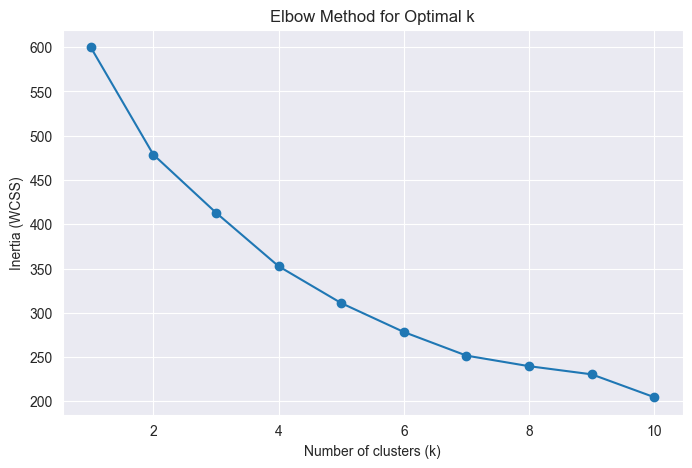

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# SCA columns
# Compute total SCA and select top 30 players
df2['TotalSCA'] = df2[sca_types].sum(axis=1)
top_sca = df2.nlargest(100, 'TotalSCA').copy()

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(top_sca[sca_types])

# Elbow method to find optimal number of clusters
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [53]:
# Calculate total SCA to select top 30 players
df['TotalSCA'] = df[sca_types].sum(axis=1)
top_sca = df.nlargest(100, 'TotalSCA').copy()

# Standardize the SCA features
scaler = StandardScaler()
X_top = scaler.fit_transform(top_sca[sca_types])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
top_sca['cluster'] = kmeans.fit_predict(X_top)

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_top)
top_sca['PC1'] = components[:, 0]
top_sca['PC2'] = components[:, 1]

# Plot the clusters using Plotly
fig = px.scatter(top_sca, x='PC1', y='PC2', color='cluster',
                 hover_name='Player',
                 title='Top 30 Players Clustered by SCA Types (PCA)',
                 labels={'cluster': 'Cluster'})

fig.show()